In this notebook I use IRBEM to map each microburst to the magnetic equator.

In [101]:
import pandas as pd
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.colors

import IRBEM

In [102]:
Re = 6371 # Earth radius, km

## Load the filtered catalog

In [125]:
CATALOG_VERSION = 6
CAT_PATH = ('/home/mike/research/ac6_microburst_scale_sizes/data/'
            'coincident_microbursts_catalogues/'
            'AC6_coincident_microbursts_sorted_v{}.txt'.format(CATALOG_VERSION))
cat = pd.read_csv(CAT_PATH)
cat_small = cat[cat.Dist_Total < 10]
cat_large = cat[cat.Dist_Total > 10]
cat.head()

,dateTime,dos1rate,peak_std,Lm_OPQ,MLT_OPQ,lat,lon,alt,Dist_In_Track,Lag_In_Track,Dist_Total,Loss_Cone_Type,flag,AE,time_cc,space_cc,time_spatial_A,time_spatial_B,peak_width_A,peak_width_B
0,2015-04-16 04:50:47.600000,560.003,5.242196,5.36905,21.77790,-71.3883,-121.5450,660.860,131.796,17.4919,131.804,1.0,0.0,583.0,0.815984,0.061890,2015-04-16 04:50:47.600000,2015-04-16 04:51:05.091900,0.175007,0.197500
1,2015-04-16 05:37:42.100000,569.946,6.014335,5.03621,10.06720,65.7251,53.1518,674.671,132.305,17.5961,132.313,1.0,0.0,552.0,0.903722,0.470579,2015-04-16 05:37:42.100000,2015-04-16 05:37:59.696100,0.295886,0.260770
2,2015-04-16 07:15:41.600000,730.004,4.564616,5.12112,10.36750,65.3316,28.9745,674.543,131.850,17.5372,131.858,1.0,0.0,618.0,0.810201,0.063204,2015-04-16 07:15:24.062800,2015-04-16 07:15:41.600000,0.305028,0.210672
3,2015-04-16 19:29:05.400000,2590.010,6.070891,5.41519,19.99470,-64.5365,26.2792,662.745,128.400,17.0482,128.409,0.0,4.0,1023.0,0.823308,0.494986,2015-04-16 19:29:05.400000,2015-04-16 19:29:22.448200,0.310256,0.317107
4,2015-04-16 20:17:02.100000,600.003,8.760751,4.19432,8.38166,61.3247,-163.4740,672.074,129.070,17.1628,129.077,1.0,0.0,1249.0,0.812830,-0.521795,2015-04-16 20:16:44.937200,2015-04-16 20:17:02.100000,0.316239,0.290001


Define a function to call IRBEM.find_magequator. This function takes a lat, lon, alt, dist_total arguments which it then splits into two sets of lat, lon, alt points assuming the dist_total is in latitude only (good assumption for polar orbiting spacecraft).

In [122]:
model = IRBEM.MagFields(kext='OPQ77')

def deltaLat(d, alt):
    """
    Calculate the half of the change in angle for a spacecraft at
    an altitude alt and separated by a distance d.
    """
    #dLat = 180/np.pi*d/(Re+alt)
    return np.rad2deg(np.arcsin(d/(2*(Re+alt))))

def map2equator(lat, lon, alt, time, d):
    """ Maps to magnetix equator assuming d is soly in latitude. """
    # Define the coordinates of the two spacecraft.
    dLat = deltaLat(d, alt)
    X1 = {'x1':alt, 'x2':lat-dLat, 'x3':lon, 'dateTime':time}
    X2 = {'x1':alt, 'x2':lat+dLat, 'x3':lon, 'dateTime':time}
    # Run IRBEM
    X1_equator = model.find_magequator(X1, None)['XGEO']
    X2_equator = model.find_magequator(X2, None)['XGEO']
    # Calculate the separations.
    d_equator = Re*np.linalg.norm(X1_equator-X2_equator)
    return d_equator

Calculate the scale sizes for all events in the sorted catalog.

In [126]:
d_equator = np.array([map2equator(row.lat, row.lon, row.alt, row.dateTime, row.Dist_Total) 
                      for _, row in cat.iterrows()])
d_small = np.array([map2equator(row.lat, row.lon, row.alt, row.dateTime, row.Dist_Total) 
                      for _, row in cat_small.iterrows()])
d_large = np.array([map2equator(row.lat, row.lon, row.alt, row.dateTime, row.Dist_Total) 
                      for _, row in cat_large.iterrows()])

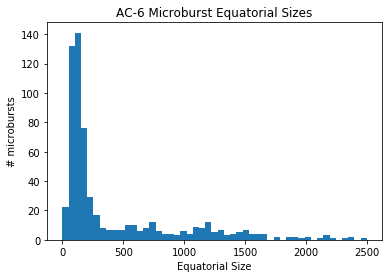

In [139]:
plt.hist(d_equator, bins=np.linspace(0, 2500, num=50))
plt.ylabel('# microbursts'); plt.xlabel('Equatorial Size'); plt.title('AC-6 Microburst Equatorial Sizes');

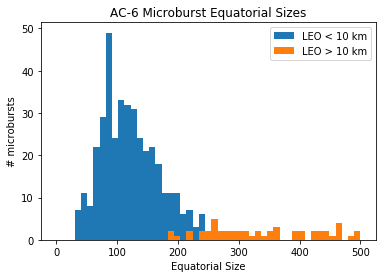

In [140]:
plt.hist(d_small, bins=np.linspace(0, 500, num=50), label='LEO < 10 km')
plt.hist(d_large, bins=np.linspace(0, 500, num=50), label='LEO > 10 km')
plt.ylabel('# microbursts'); plt.xlabel('Equatorial Size'); plt.title('AC-6 Microburst Equatorial Sizes');
#plt.xscale('log')
plt.legend();

The above histogram is very close to the results by Santolik and Gurnett, 2003 "Transverse dimensions of chorus in the source region" paper although this is not normalized or a CDF.

Calculate the equatorial CDF. 

In [107]:
bin_width = 25
bins = np.arange(0, 2000, bin_width)
total_detections = d_equator.shape[0]
cdf = np.array([len(np.where(d_equator > d)[0])/total_detections for d in bins])
pdf = (cdf[:-1] - cdf[1:])/bin_width

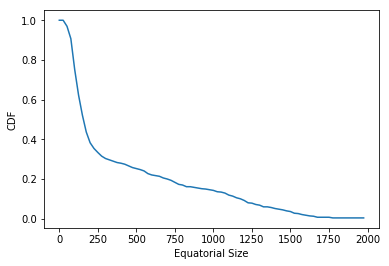

In [108]:
plt.plot(bins, cdf); plt.xlabel('Equatorial Size'); plt.ylabel('CDF');

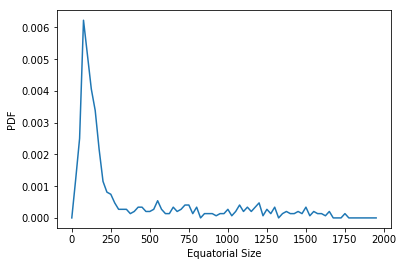

In [109]:
plt.plot(bins[:-1], pdf); plt.xlabel('Equatorial Size'); plt.ylabel('PDF');

The very significant peak is around 80 km, which once again agrees with Santolik et al., 2003 paper as they found significant chorus element cross-correlation in the transverse direction up to 100 km.

## Check
How would a 1 km sized microburst scales to the magnetic equator as a function of L shell?

In [110]:
lon = 180
lat_arr = np.linspace(60, 75)
time = '2019-03-18T00:00:00'
d_scale = np.array([map2equator(lat_i, lon, 500, time, 1) for lat_i in lat_arr])
output = model.make_lstar({'x1':500*np.ones_like(lat_arr), 'x2':lat_arr, 'x3':lon*np.ones_like(lat_arr), 
                  'dateTime':[time]*len(lat_arr)}, None)
output['Lm'] = np.abs(output['Lm'])

Mean MLT = 10.568432137166504


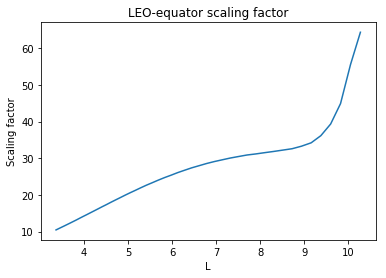

In [111]:
plt.plot(output['Lm'], d_scale); plt.xlabel('L'); plt.ylabel('Scaling factor'); 
plt.title('LEO-equator scaling factor')
print('Mean MLT =', np.mean(output['MLT']))

Now explore this space in L-MLT space.

In [112]:
lon_arr = np.linspace(-180, 180)
lat_arr = np.linspace(40, 75)
lonlon, latlat = np.meshgrid(lon_arr, lat_arr)
d_scale_matrix = np.nan*np.ones_like(lonlon)
L_matrix = np.nan*np.ones_like(lonlon)
MLT_matrix = np.nan*np.ones_like(lonlon)
time = '2019-03-18T00:00:00'

for i_lon in range(lonlon.shape[0]):
    for i_lat in range(lonlon.shape[1]):
        
        d = model.make_lstar({'x1':500, 'x2':latlat[i_lon, i_lat], 'x3':lonlon[i_lon, i_lat], 
                  'dateTime':time}, None)
        if np.abs(d['Lm']) < 10:
            L_matrix[i_lon, i_lat] = np.abs(d['Lm'])
            MLT_matrix[i_lon, i_lat] = np.abs(d['MLT'])
            d_scale_matrix[i_lon, i_lat] = map2equator(latlat[i_lon, i_lat], 
                                                      lonlon[i_lon, i_lat], 500, time, 1)

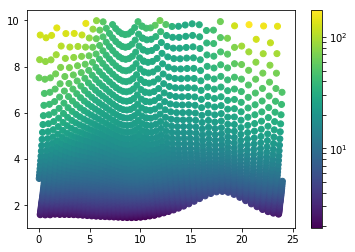

In [113]:
sc = plt.scatter(MLT_matrix, L_matrix, c=d_scale_matrix, norm=matplotlib.colors.LogNorm())
plt.colorbar(sc);

In [114]:
L_matrix

array([[1.57518707, 1.6206186 , 1.67280353, ..., 1.50743125, 1.53743318,
        1.57518707],
       [1.60319483, 1.64986207, 1.70395353, ..., 1.53385787, 1.56430206,
        1.60319483],
       [1.63274679, 1.68080669, 1.73708234, ..., 1.56175634, 1.59286524,
        1.63274679],
       ...,
       [9.23042785, 9.65966666,        nan, ..., 8.62493092, 8.88532281,
        9.23042785],
       [9.74885261,        nan,        nan, ..., 9.14454621, 9.40197855,
        9.74885261],
       [       nan,        nan,        nan, ..., 9.68495126, 9.94172639,
               nan]])

## Scale my results to one L shell to remove bias.
Santolik et al., 2003 used CLUSTER observations from L = 4.4 (Need to confirm that its L = 4.4 or L = 3.4). At 2002-04-18T08:20:30Z L = 4.3 and at 2002-04-18T09:30:30Z L = 4.7

First, find the LLA that corresponds to MLT = 21, and L = 4.4. LLA for L = 4.4 is [54, -55, 500]. LLA for L = 3.4 is [54, -35, 500]

In [115]:
template_LLA = [54, -35, 500]
model.make_lstar({'x1':template_LLA[2], 
                  'x2':template_LLA[0], 
                  'x3':template_LLA[1], 
                  'dateTime':time}, 
                 None)

{'Lm': [-3.420564115337106],
 'MLT': [22.176411860469834],
 'blocal': [40730.645992677506],
 'bmin': [698.5619601090855],
 'Lstar': [-1e+31],
 'xj': [6.609132447464969]}

In [116]:
template_scale = map2equator(*template_LLA, time, 1)
print('Santolik scaling factor =', template_scale)

Santolik scaling factor = 11.1385232161647


In [117]:
map2equator_wrapper = lambda row: map2equator(row.lat, row.lon, row.alt, row.dateTime, row.Dist_Total)
map2equator_scale = lambda row: map2equator(row.lat, row.lon, row.alt, row.dateTime, 1)
d_equator_norm = np.array([map2equator_wrapper(row)*template_scale/map2equator_scale(row)
                      for _, row in cat.iterrows()])

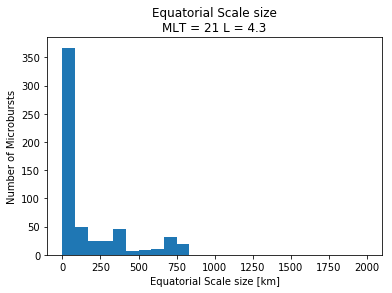

In [118]:
plt.hist(d_equator_norm, bins=np.linspace(0, 2000, num=25));
plt.title(f'Equatorial Scale size\nMLT = {21} L = {4.3}');
plt.xlabel('Equatorial Scale size [km]'); plt.ylabel('Number of Microbursts');

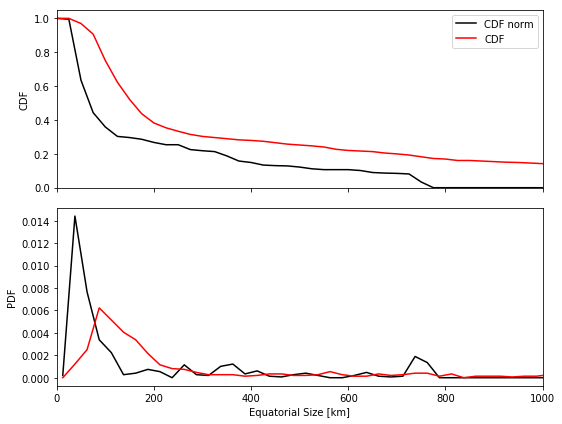

In [119]:
total_detections = d_equator_norm.shape[0]
cdf_norm = np.array([len(np.where(d_equator_norm > d)[0])/total_detections for d in bins])
pdf_norm = (cdf_norm[:-1] - cdf_norm[1:])/bin_width

fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
ax[0].plot(bins, cdf_norm, label='CDF norm', c='k'); 
ax[1].plot(bins[:-1]+bin_width/2, pdf_norm, c='k'); 
ax[0].plot(bins, cdf, label='CDF', c='r'); 
ax[1].plot(bins[:-1]+bin_width/2, pdf, c='r');
ax[0].set_ylabel('CDF');
ax[1].set_xlabel('Equatorial Size [km]'); ax[1].set_ylabel('PDF');
ax[0].legend();
ax[1].set_xlim(0, 1000)
ax[0].set_ylim(bottom=0)
plt.tight_layout()